**OTUS Machine Learning Advanced**

### **Homework 5**

### Building a model to predict protein expression from PPI graph data

![proteins](https://user-images.githubusercontent.com/73858914/172504903-f533b8ea-4135-4c2d-9dd3-463fc14a10d1.png)

**Goals:**

- Predict proteins expression given a graph of PPI   

**Means**:

- Notebook relies mostly on [networkx](https://github.com/networkx/networkx) and [node2vec](https://github.com/eliorc/node2vec) libraries

**Data source**:
  
Dataset represents a graph of PPI. Proteins are nodes and their interactions are edges.

Proteins' expression data is split in [`train`](https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv) and [`test`](https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv) sets. 
Interaction information is provided in [`edges`](https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv).   
    
**Approach to the problem**:

1. We will build the graph's embedding in 128-dimensional space
2. Using this embedding as a feature space and protein expression as target variable,   
we will apply support vector regressor (`SVR` from sklearn) with `rbf` kernel for prediction.

**Binder notebook:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/oort77/OTUS_ADV_HW5/main)

### Import libraries

In [1]:
import networkx as nx
from node2vec import Node2Vec as n2v
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
random_seed =17

### Import data

In [3]:
edges = pd.read_csv("./data/edges", sep=",", dtype="int32")

In [4]:
train = pd.read_csv("./data/train", sep=",")

In [5]:
edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [6]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594174 entries, 0 to 594173
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   node_1  594174 non-null  int32
 1   node_2  594174 non-null  int32
dtypes: int32(2)
memory usage: 4.5 MB


In [7]:
train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


### Build networkx graph

In [8]:
G = nx.Graph()

#### Edges

In [9]:
[G.add_edge(edges.loc[idx, "node_1"], edges.loc[idx, "node_2"]) for idx in edges.index];

In [10]:
G.number_of_edges()

594174

#### Nodes

In [11]:
train.set_index("node", drop=True, inplace=True)

for i in train.index:
    G.nodes[i]["target"] = train.loc[i,"target"]

In [12]:
G.number_of_nodes()

10000

In [13]:
G.nodes[4]

{'target': 0.2619481383126331}

In [14]:
G.nodes[4]['target']

0.2619481383126331

#### Nodes with and without labels

In [15]:
list(G.nodes.data())[:10]

[(344, {'target': 0.631430702306045}),
 (50, {'target': 1.741759586945974}),
 (153, {'target': 9.493606672113676}),
 (532, {'target': 0.5068173156903958}),
 (679, {'target': 1.3977076394467955}),
 (986, {'target': 0.762218566423884}),
 (1169, {'target': 2.693997791194838}),
 (1300, {}),
 (1398, {'target': 0.2503542574333443}),
 (1479, {'target': 0.5506688650076211})]

In [16]:
list(G.nodes())[:5]

[344, 50, 153, 532, 679]

#### Graph info

In [18]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10000
Number of edges: 594174
Average degree: 118.8348


### Build an embedding with node2vec

In [19]:
WINDOW = 10 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(
    G,
    p=1,
    q=2,
    walk_length=120,# number of nodes in each walk (default: 80)
    num_walks=10
)

Computing transition probabilities:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [11:08<00:00, 66.90s/it]


In [20]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS,
    seed = random_seed,
)

#### Nodes similar to a given one

In [21]:
input_node = '344'
for s in mdl.wv.most_similar(input_node, topn = 5):
    print(s)

('24', 0.6140180230140686)
('418', 0.6096556186676025)
('951', 0.5878692269325256)
('27', 0.5863542556762695)
('7819', 0.5773722529411316)


#### Create an embedding dataframe

In [22]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
344,-0.603872,0.449364,0.381323,-0.132966,0.065625,0.312330,0.187642,-0.162750,0.065385,0.027902,...,0.315358,0.206176,0.343120,0.362108,0.194538,0.222225,-0.050177,-0.242995,0.109812,0.007522
50,-0.120421,-0.014227,0.125733,-0.231298,-0.083052,-0.113622,0.031269,-0.187788,-0.023478,0.036569,...,-0.188641,0.185668,-0.120594,-0.008376,-0.205739,-0.448701,-0.005748,-0.002783,-0.094625,0.153817
153,-0.043279,0.020732,0.130487,-0.047516,0.047554,-0.030416,-0.084254,-0.041948,-0.273197,0.156113,...,0.122638,-0.095910,0.136091,0.095324,-0.118770,0.005800,-0.025743,0.025795,-0.002380,0.217008
532,-0.502988,0.217875,-0.137488,-0.177832,0.245123,0.218593,0.082095,-0.438127,0.241803,-0.291919,...,0.093201,-0.225769,0.274470,0.018423,0.174912,-0.091131,-0.206002,-0.090939,-0.031351,0.086127
679,-0.133608,0.543155,0.144656,-0.106857,-0.120954,0.024159,0.121004,-0.217852,0.181342,0.077488,...,-0.056794,0.067648,0.002798,-0.201443,0.283420,-0.069538,0.023452,-0.024501,-0.012840,0.012247


### Visualuze embedding with PCA

<Figure size 432x288 with 0 Axes>

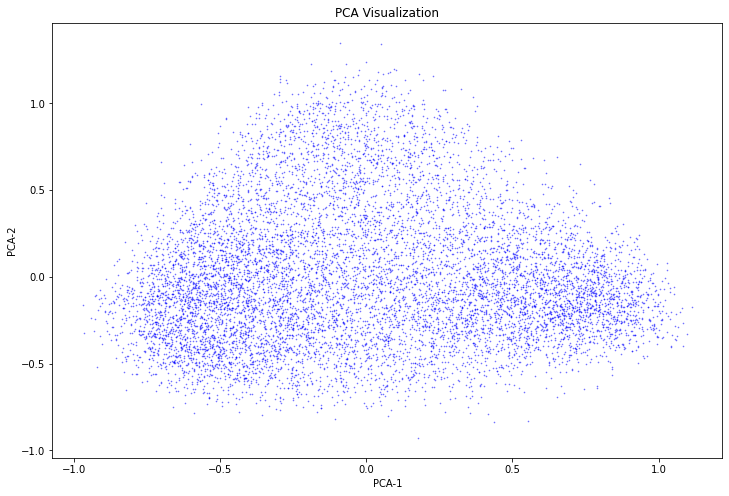

In [23]:
pca = PCA(n_components = 2, random_state = random_seed)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(12,8))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'blue',
    alpha = 0.5
)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Visualization')
plt.show()

### Build train-validation split

In [24]:
data = emb_df.join(train)

In [25]:
# test = data[data["target"].isna()]

In [26]:
df = data[data["target"].notna()]

#### Take log of target

In [27]:
X = df.drop(columns={"target"})
y = np.log1p(df["target"])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_seed)

### Initialize and fit regressor

In [29]:
reg = SVR(C=0.3)
reg.fit(X_train, y_train)

SVR(C=0.3)

#### Sample prediction

In [30]:
reg.predict(X_test[1:2])

array([0.46616749])

### Regression results on train-validation split

In [31]:
mse = mean_squared_error(y_test, reg.predict(X_test))
mape = mean_absolute_percentage_error(y_test, reg.predict(X_test))
r2 = r2_score(y_test, reg.predict(X_test))
print(f"RMSE on test set: {np.sqrt(mse):.4f}")
print(f"MAPE on test set: {mape*100:.2f}%")
print(f"R2 on test set: {r2:.2f}")

RMSE on test set: 0.1063
MAPE on test set: 23.78%
R2 on test set: 0.83


In [32]:
mse_train = mean_squared_error(y_train, reg.predict(X_train))
mape_train = mean_absolute_percentage_error(y_train, reg.predict(X_train))
r2_train = r2_score(y_train, reg.predict(X_train))
print(f"RMSE on train set: {np.sqrt(mse_train):.4f}")
print(f"MAPE on train set: {mape_train*100:.2f}%")
print(f"R2 on train set: {r2_train:.2f}")

RMSE on train set: 0.0803
MAPE on train set: 20.41%
R2 on train set: 0.90


### Baseline model (median value of target)

In [33]:
y_train_median = np.median(y_train)
yb = np.ones(y_test.shape)*y_train_median

In [34]:
mse_test = mean_squared_error(y_test, yb)
mape_test = mean_absolute_percentage_error(y_test, yb)
r2_test = r2_score(y_test, yb)
print('Baseline model:\n')
print(f"RMSE on test set: {np.sqrt(mse_test):.4f}")
print(f"MAPE on test set: {mape_test*100:.2f}%")
print(f"R2 on test set: {r2_test:.2f}")

Baseline model:

RMSE on test set: 0.2761
MAPE on test set: 30.79%
R2 on test set: -0.12


<div class="alert alert-info">
<b>OBSERVATION:</b> SVR model beats baseline by a good margin on train-validation split.
</div>

### Check SVR model on `test` data

#### Import `test` dataset

In [35]:
test = pd.read_csv("./data/test", sep=",")
test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


In [36]:
test.set_index("node", drop=True, inplace=True)
test.head()

,target
node,
817,0.279231
9574,0.380795
1607,0.686527
4782,0.303594
24125,0.367374


#### Take log of test `target`

In [37]:
yhat=np.log1p(test)
X = emb_df.loc[test.index]

In [38]:
test.index[42] in G.nodes()

True

<div class="alert alert-info">
<b>NOTE:</b> Nodes from the `test` set are already in the embedding.
</div>

### Fit SVR on all train data

In [39]:
reg.fit(X_train, y_train)

SVR(C=0.3)

###  Predictions on test - metrics

In [40]:
mse = mean_squared_error(yhat, reg.predict(X))
mape = mean_absolute_percentage_error(yhat, reg.predict(X))
r2 = r2_score(yhat, reg.predict(X))
print(f"RMSE on  test set: {np.sqrt(mse):.4f}")
print(f"MAPE on  test set: {mape*100:.2f}%")
print(f"R2 on  test set: {r2:.2f}")

RMSE on  test set: 0.1062
MAPE on  test set: 24.28%
R2 on  test set: 0.86


<div class="alert alert-info">
<b>OBSERVATION:</b> SVR model on test shows the same, if not better results on test data, than on validation set.
</div>

### CONCLUSION

The model built shows decent results, beating baseline. There certainly are ways to improve it's performance by tuning various embedding hyperparameters.

###  ADDENDUM: Small exercise in graph visualisation

#### Draw neighbours of a particular node

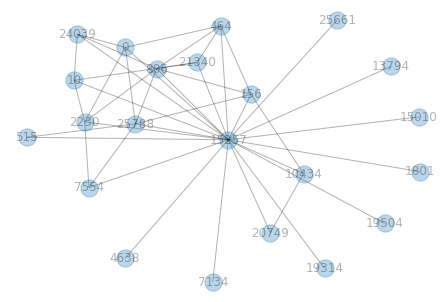

In [41]:
cnode = 15257
def nbs(node):
    nbrs = list(G.neighbors(cnode))
    nbrs.append(cnode)
    return node in nbrs
        
H = nx.subgraph_view(G, filter_node=nbs)
H.nodes()
nx.draw_spring(H, with_labels=True, alpha=0.3)